<a href="https://colab.research.google.com/github/girinath18/img2img_GM/blob/main/InstructIR_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InstructIR ✏️🖼️
## High-Quality Image Restoration Following Human Instructions

[Marcos V. Conde](https://scholar.google.com/citations?user=NtB1kjYAAAAJ&hl=en), [Gregor Geigle](https://scholar.google.com/citations?user=uIlyqRwAAAAJ&hl=en), [Radu Timofte](https://scholar.google.com/citations?user=u3MwH5kAAAAJ&hl=en)


Original Code and Material: [https://github.com/mv-lab/InstructIR](https://github.com/mv-lab/InstructIR)

<a href="https://github.com/mv-lab/InstructIR"><img src="https://i.ibb.co/Xp5bJ7n/instructir-teaser.png" alt="InstructIR" border="0"></a>


<br>

> **Abstract:** Image restoration is a fundamental problem that involves recovering a high-quality clean image from its degraded observation. All-In-One image restoration models can effectively restore images from various types and levels of degradation using degradation-specific information as prompts to guide the restoration model. In this work, we present the first approach that uses human-written instructions to guide the image restoration model. Given natural language prompts, our model can recover high-quality images from their degraded counterparts, considering multiple degradation types. Our method, InstructIR, achieves state-of-the-art results on several restoration tasks including image denoising, deraining, deblurring, dehazing, and (low-light) image enhancement. InstructIR improves +1dB over previous all-in-one restoration methods. Moreover, our dataset and results represent a novel benchmark for new research on text-guided image restoration and enhancement.

### 1. Download code from the official github: https://github.com/mv-lab/InstructIR

In [ ]:
import sys
import os

!git clone https://github.com/mv-lab/InstructIR.git
sys.path.append("InstructIR/")

fatal: destination path 'InstructIR' already exists and is not an empty directory.


In [ ]:
os.chdir("InstructIR/")
!ls

app.py	 data	     images	 LICENSE  __pycache__  requirements_gradio.txt	text
configs  demo.ipynb  index.html  models   README.md    static			utils.py


In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random

from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Check the config file at `configs/eval5d.yml` for more context.

In [ ]:
CONFIG     = "configs/eval5d.yml"
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

Create the InstructIR model using the provided pre-trained weights at `models/`.
- You will need to load the image model `im_`
- and the language model `lm_`

In [ ]:
!ls models/

im_instructir-7d.pt  instructir.py  lm_instructir-7d.pt  nafnet.py  nafnet_utils.py  __pycache__


In [ ]:
print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
cpu
IMAGE MODEL CKPT: models/im_instructir-7d.pt
Loaded weights! 15.843363


In [ ]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head #.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


# Running InstructIR!

In [ ]:
def process_img (image, prompt):
    """
    Given an image and a prompt, we run InstructIR to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd #.to(device)
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img

You need to feed into the function and RGB image and a simple instruction (string).

Check `load_img` from `utils.py` we just use PIL to load a given image.
You can find more sample images in `images/`

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


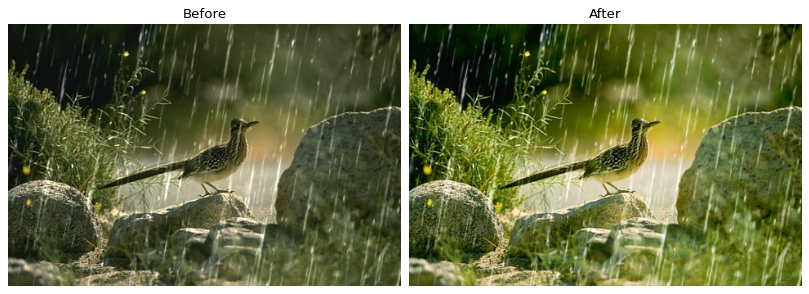

In [ ]:
IMG    = "images/rain-020.png"
PROMPT = "Retouch the picture as a professional photographer please"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

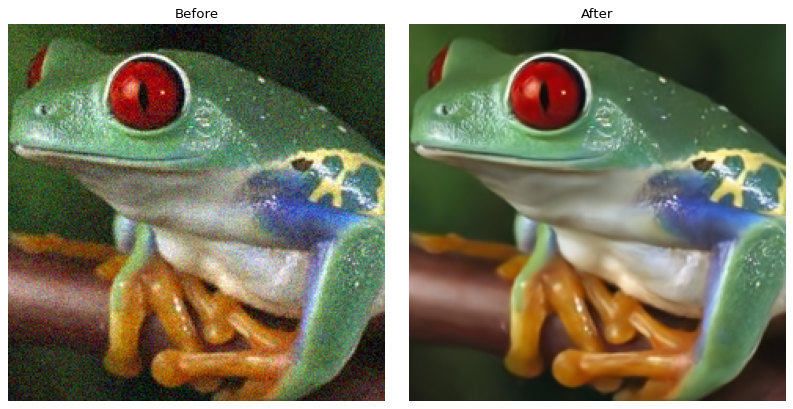

In [ ]:
IMG    = "images/frog.png" # from RealSRSet
PROMPT = "Can you remove the little dots in the image? is very unpleasant"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

### Control the process

Sometimes the blur, rain, or film grain noise are pleasant effects and part of the **"aesthetics"**.

Here we show a simple example on how to interact with InstructIR
> Disclaimer: please remember this is not a product, thus, you will notice some limitations.

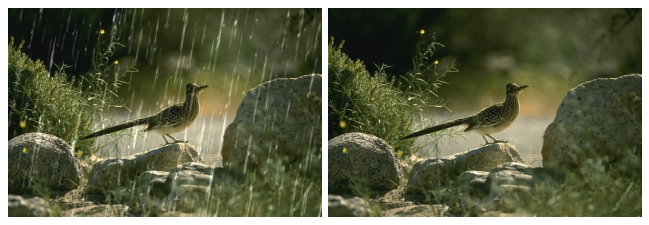

In [ ]:
IMG    = "images/rain-020.png"
image  = load_img(IMG)

PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

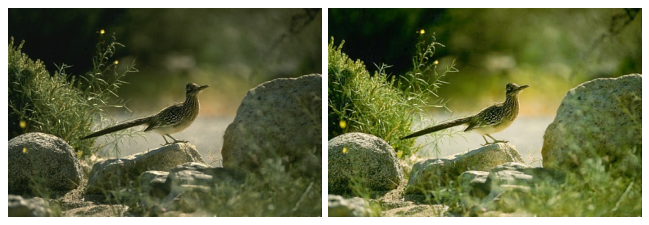

In [ ]:
PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )
plot_all([result1, result2], figsize=(8,4))

The final result looks indeed stunning :)

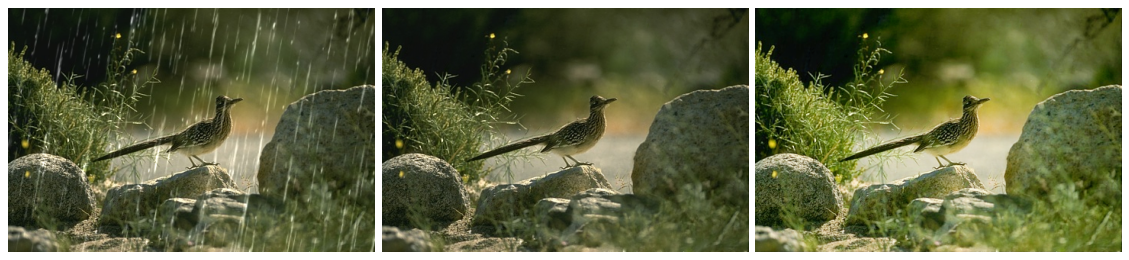

In [ ]:
plot_all([image, result1, result2], figsize=(14,7))